<a href="https://colab.research.google.com/github/joaopamaral/tcc_puc_cdbd/blob/master/Analise_Storybook_CENIPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise dados CENIPA para construção do Storybook

![Descrição CENIPA](https://raw.githubusercontent.com/zezente/opendata_aig_brazil/master/reference/data_model.png)

## Importando as bibliotecas utilizadas

In [0]:
import pandas as pd
import folium
from folium import plugins
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

In [0]:
# Removendo warning de depreciação do matlab utilizado no Seaborn
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

## Realizando leitura dos dados da CENIPA

In [0]:
def get_cenipa_data():
    """Retorna os dados abertos da Cenipa em dataframes"""
    cenipa_url = 'http://sistema.cenipa.aer.mil.br/cenipa/media/opendata'

    oco_df = pd.read_csv(f'{cenipa_url}/oco.csv', sep='~', index_col='codigo_ocorrencia', parse_dates=['ocorrencia_dia'])
    ftc_df = pd.read_csv(f'{cenipa_url}/ftc.csv', sep='~')
    rec_df = pd.read_csv(f'{cenipa_url}/rec.csv', sep='~')
    anv_df = pd.read_csv(f'{cenipa_url}/anv.csv', sep='~')

    return oco_df, ftc_df, rec_df, anv_df

oco_df, ftc_df, rec_df, anv_df = get_cenipa_data()

### Analisando principais fatores (max top 15 por visualização)

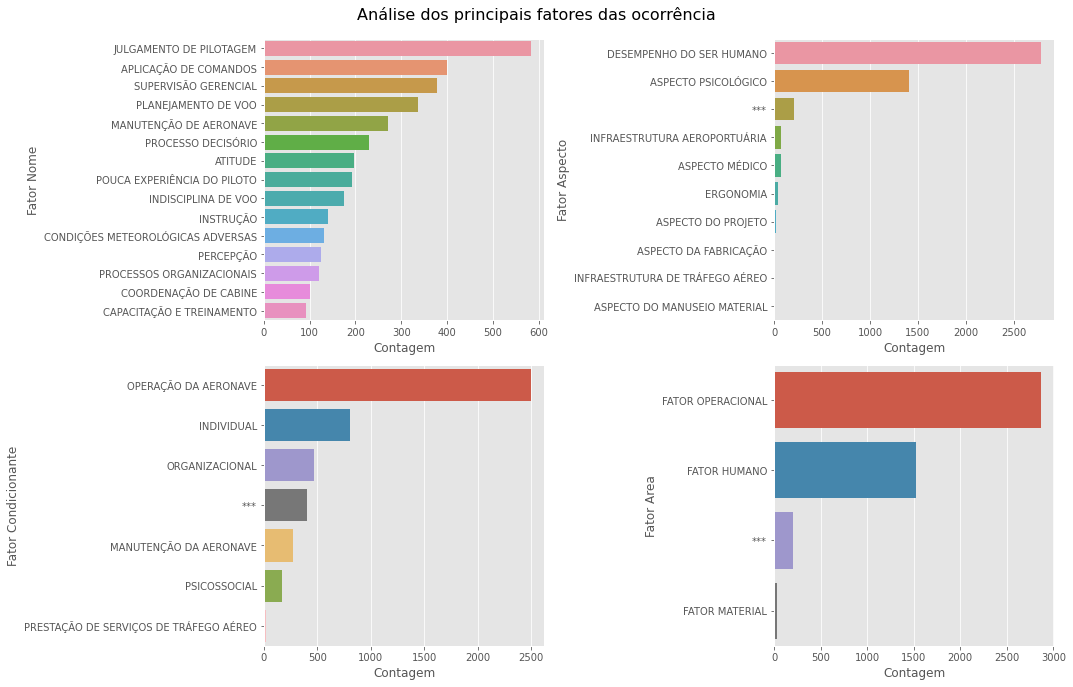

In [63]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))

for i, col in enumerate(['fator_nome', 'fator_aspecto', 'fator_condicionante', 'fator_area']):
    sns.countplot(y=col, data=ftc_df, order=ftc_df[col].value_counts().iloc[:15].index, ax=ax[i // 2][i % 2])
    ax[i // 2][i % 2].set(xlabel='Contagem', ylabel=col.replace('_', ' ').title())

fig.suptitle('Análise dos principais fatores das ocorrência', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### Realizando join da tabela de fatores e concatenando as colunas de fatores

In [0]:
for col in ['fator_nome', 'fator_aspecto', 'fator_condicionante', 'fator_area']:
    oco_df = oco_df.join(ftc_df[['codigo_ocorrencia', col]].drop_duplicates().groupby('codigo_ocorrencia')[col].apply(', '.join))

In [14]:
oco_df.loc[:, oco_df.columns.str.contains('fator_')]

,fator_nome,fator_aspecto,fator_condicionante,fator_area
codigo_ocorrencia,,,,
201305055424986,NaN,NaN,NaN,NaN
201311259977425,"COORDENAÇÃO DE CABINE, ESQUECIMENTO DO PILOTO",DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
201605160250139,"PERCEPÇÃO, PROCESSO DECISÓRIO, PROCESSOS ORGAN...","ASPECTO PSICOLÓGICO, DESEMPENHO DO SER HUMANO","INDIVIDUAL, ORGANIZACIONAL, OPERAÇÃO DA AERONAVE","FATOR HUMANO, FATOR OPERACIONAL"
201805021421302,NaN,NaN,NaN,NaN
201103187273112,NaN,NaN,NaN,NaN
...,...,...,...,...
201107163514591,NaN,NaN,NaN,NaN
201101107541931,NaN,NaN,NaN,NaN
201502247981603,NaN,NaN,NaN,NaN


### Adicionando o total de fatalidades a análise

In [0]:
oco_df = oco_df.join(anv_df.groupby('codigo_ocorrencia')['total_fatalidades'].sum())

In [16]:
print(f'Quantidade de ocorrências: {oco_df.shape[0]}')
print(f'Ocorrências registradas de {oco_df.ocorrencia_dia.min().date()} a {oco_df.ocorrencia_dia.max().date()}')
display(oco_df.head())
print('\n')
display(oco_df.describe(include='all'))

Quantidade de ocorrências: 5460
Ocorrências registradas de 2009-01-01 a 2019-05-29


,ocorrencia_classificacao,ocorrencia_tipo,ocorrencia_tipo_categoria,ocorrencia_tipo_icao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_horario,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista,ocorrencia_dia_extracao,fator_nome,fator_aspecto,fator_condicionante,fator_area,total_fatalidades
codigo_ocorrencia,,,,,,,,,,,,,,,,,,,,,,,,,,
201305055424986,ACIDENTE,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DO MOTOR,SCF-PP,-9.9085,-63.0333,ARIQUEMES,RO,BRASIL,SJOG,2013-05-05,11:00:00,NaN,FINALIZADA,***,NÃO,NaN,0,1,NÃO,2019-05-31,NaN,NaN,NaN,NaN,0
201311259977425,INCIDENTE GRAVE,POUSO SEM TREM,CONTATO ANORMAL COM A PISTA,ARC,-11.4956,-61.4508,CACOAL,RO,BRASIL,SSKW,2013-11-25,12:32:00,NaN,FINALIZADA,IG-209/CENIPA/2013,SIM,2014-04-07,0,1,NÃO,2019-05-31,"COORDENAÇÃO DE CABINE, ESQUECIMENTO DO PILOTO",DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,0
201605160250139,INCIDENTE GRAVE,COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO,COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO,CTOL,-11.2644,-61.2589,CACOAL,RO,BRASIL,SSKW,2016-05-13,19:19:00,SIM,FINALIZADA,IG-084/CENIPA/2016,SIM,2019-03-11,7,1,NÃO,2019-05-31,"PERCEPÇÃO, PROCESSO DECISÓRIO, PROCESSOS ORGAN...","ASPECTO PSICOLÓGICO, DESEMPENHO DO SER HUMANO","INDIVIDUAL, ORGANIZACIONAL, OPERAÇÃO DA AERONAVE","FATOR HUMANO, FATOR OPERACIONAL",0
201805021421302,INCIDENTE,AERÓDROMO,AERÓDROMO,ADRM,-11.4956,-61.4508,CACOAL,RO,BRASIL,SSKW,2018-03-09,22:40:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO,2019-05-31,NaN,NaN,NaN,NaN,0
201103187273112,INCIDENTE,OUTROS,OUTROS,OTHR,-13.1950,-60.8184,CEREJEIRAS,RO,BRASIL,****,2011-03-18,13:30:00,NaN,FINALIZADA,***,NÃO,NaN,0,1,NÃO,2019-05-31,NaN,NaN,NaN,NaN,0


,ocorrencia_classificacao,ocorrencia_tipo,ocorrencia_tipo_categoria,ocorrencia_tipo_icao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_horario,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista,ocorrencia_dia_extracao,fator_nome,fator_aspecto,fator_condicionante,fator_area,total_fatalidades
count,5460,5460,5460,5460,5460.000000,5460.000000,5460,5460,5460,5460,5460,5460,1519,5460,5460,5460,1375,5460.000000,5460.000000,5460,5460,1126,1126,1126,1126,5460.000000
unique,3,71,31,29,NaN,NaN,1050,28,1,480,2822,935,3,2,1788,2,213,NaN,NaN,2,1,654,64,88,19,NaN
top,INCIDENTE,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP,NaN,NaN,RIO DE JANEIRO,SP,BRASIL,****,2013-12-18 00:00:00,20:00:00,SIM,FINALIZADA,***,NÃO,2017-08-01,NaN,NaN,NÃO,2019-05-31,MANUTENÇÃO DE AERONAVE,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,NaN
freq,3073,651,1160,1723,NaN,NaN,319,1310,5460,2172,9,114,1406,4875,3389,4089,62,NaN,NaN,5009,5460,63,518,355,553,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,-18.193427,-47.492499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.378571,1.011538,NaN,NaN,NaN,NaN,NaN,NaN,0.157875
std,NaN,NaN,NaN,NaN,8.894486,10.949421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.350778,0.115062,NaN,NaN,NaN,NaN,NaN,NaN,0.784059
min,NaN,NaN,NaN,NaN,-224.164700,-72.781100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,-23.330300,-51.171100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


## Analisando as ocorrências no Brasil

### Análise temporal das ocorrências

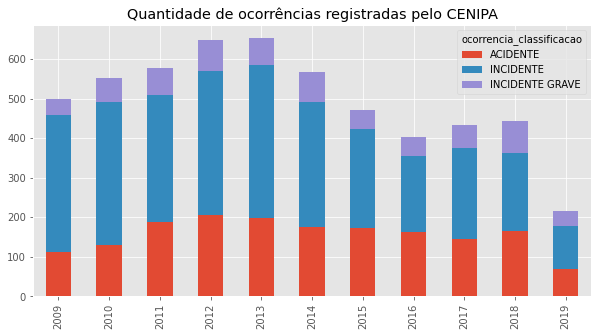

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
oco_df.groupby([oco_df.ocorrencia_dia.dt.year, 'ocorrencia_classificacao'])['ocorrencia_tipo'].count().unstack().plot.bar(
    stacked=True, title="Quantidade de ocorrências registradas pelo CENIPA", ax=ax);
ax.set(xlabel="");

### Análise geográfica das ocorrências

In [24]:
def plot_heatmap_brazil(lat_log_data, title):
    print(title)
    fig = folium.Figure(width=700, height=500, title=title)
    m=folium.Map([-15.4647,-47.5547], zoom_start=4)
    # plot heatmap
    m.add_child(plugins.HeatMap(lat_log_data, radius=15))
    m.add_to(fig)
    return fig

plot_heatmap_brazil(oco_df[['ocorrencia_latitude', 'ocorrencia_longitude']].values, title='Localização das Ocorrências no Brasil')

Localização das Ocorrências no Brasil


In [32]:
filtro_fator_humano = (oco_df.fator_area.str.contains('FATOR HUMANO') | oco_df.fator_aspecto.str.contains('DESEMPENHO DO SER HUMANO'))
oco_df['FATOR HUMANO'] = filtro_fator_humano
location_data_humano = oco_df.loc[filtro_fator_humano, ['ocorrencia_latitude', 'ocorrencia_longitude']].values

plot_heatmap_brazil(location_data_humano, title='Localização das Ocorrências no Brasil devido o Fator Humano')

Localização das Ocorrências no Brasil devido o Fator Humano


### Análise dos fatores

In [25]:
display(ftc_df.head())
print('\n')
display(ftc_df.describe(include='all'))

,codigo_ocorrencia,fator_nome,fator_aspecto,fator_condicionante,fator_area,fator_detalhe_fator,fator_dia_extracao
0,200901015424167,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,"A PROVÁVEL INTENÇÃO EM PRESERVAR A AERONAVE, C...",2019-05-31
1,200901015424167,MANUTENÇÃO DE AERONAVE,DESEMPENHO DO SER HUMANO,MANUTENÇÃO DA AERONAVE,FATOR OPERACIONAL,O RELATÓRIO TÉCNICO DO IAE REVELOU FALHAS ORIU...,2019-05-31
2,200901015424167,SUPERVISÃO GERENCIAL,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,O OPERADOR NÃO PROGRAMOU A REALIZAÇÃO DE INSPE...,2019-05-31
3,200901055963381,ATITUDE,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO,O PILOTO ERA POUCO EXPERIENTE E REALIZOU O POU...,2019-05-31
4,200901055963381,PROCESSO DECISÓRIO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO,"A POUCA EXPERIÊNCIA DO PILOTO, ALIADA AO EXCES...",2019-05-31


,codigo_ocorrencia,fator_nome,fator_aspecto,fator_condicionante,fator_area,fator_detalhe_fator,fator_dia_extracao
count,4.630000e+03,4630,4630,4630,4630,2710,4630
unique,NaN,68,10,7,4,2685,1
top,NaN,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,SUMA,2019-05-31
freq,NaN,583,2782,2496,2866,10,4630
mean,2.012628e+14,NaN,NaN,NaN,NaN,NaN,NaN
std,2.533158e+11,NaN,NaN,NaN,NaN,NaN,NaN
min,2.009010e+14,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.010121e+14,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.012100e+14,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.015020e+14,NaN,NaN,NaN,NaN,NaN,NaN


#### Impacto do fator humano em relação ao total de fatalidades

,TOTAL DE FATALIDADES
FATOR HUMANO,486
OUTROS FATORES,376


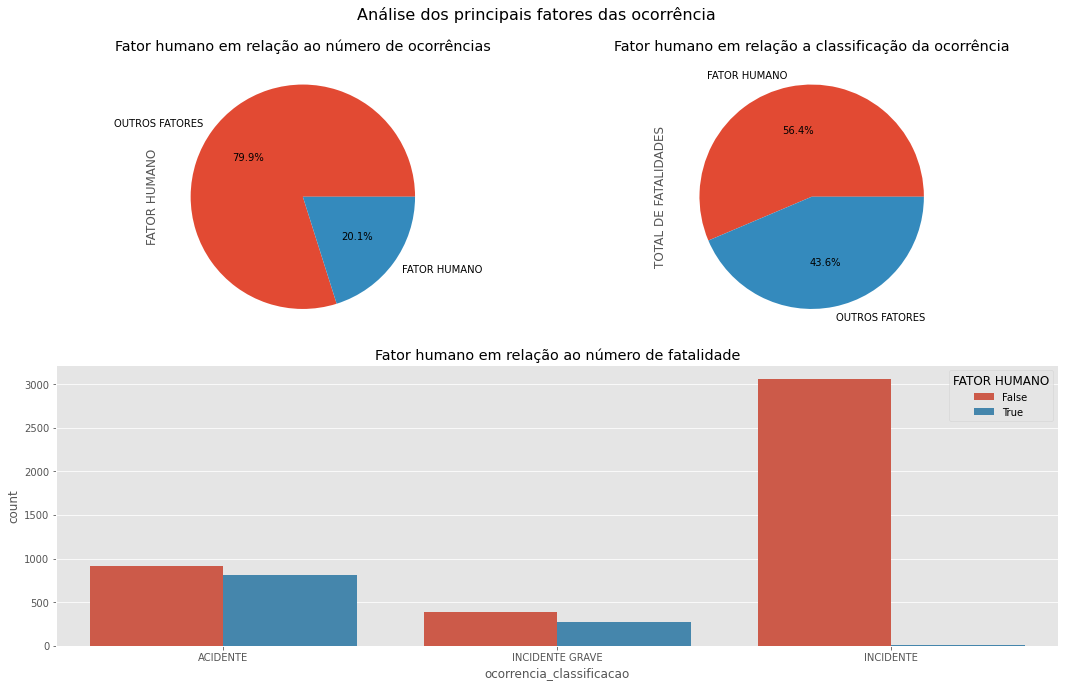

In [62]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(gs[0, 0]) # row 0, col 0
ax2 = plt.subplot(gs[0, 1]) # row 0, col 1
ax3 = plt.subplot(gs[1, :]) # row 1, span all columns

fatal_df = pd.DataFrame([oco_df.loc[filtro_fator_humano, 'total_fatalidades'].sum(), 
                         oco_df.loc[~filtro_fator_humano, 'total_fatalidades'].sum()], ['FATOR HUMANO', 'OUTROS FATORES'], ['TOTAL DE FATALIDADES'])
display(fatal_df)
print('\n\n')

oco_df['FATOR HUMANO'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax1, labels=['OUTROS FATORES', 'FATOR HUMANO']);
sns.countplot(x='ocorrencia_classificacao', hue='FATOR HUMANO', data=oco_df, ax=ax3)
fatal_df['TOTAL DE FATALIDADES'].plot.pie(autopct='%1.1f%%', ax=ax2);

ax1.set_title('Fator humano em relação ao número de ocorrências')
ax2.set_title('Fator humano em relação a classificação da ocorrência')
ax3.set_title('Fator humano em relação ao número de fatalidade')

fig.suptitle('Análise dos principais fatores das ocorrência', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])